### Group: Dig Data
### Group Memeber: Yu Qiao (Tom) Chen, Qinyuan Lu, Yiran Ye, Qianqian Song

# 0. Business Problem 

## 0.1 Identify the Business Problem

## 0.2 Data

We combined 2 different datasets: 

Bike Trips:

We used datasets from Citi Bike: Daily Ridership and Membership Data, and Trip Histories.
https://www.citibikenyc.com/system-data

Weather:

Weather dataset included daily weather summaries for the year of 2020 in Jersey City and have multiple dimensions. We selected the following quantitative dimensions that best represent what bike users would care about the most: Air Temperature, Precipitation, Wind Speed, and Humidity.
http://newa.cornell.edu/index.php?page=hourly-weather

### Import data:

In [2]:
import pandas as pd
import numpy as np

from pylab import rcParams

import matplotlib.pyplot as plt
import seaborn as sns 

import statsmodels.api as sm
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import *
from sklearn.kernel_ridge import *
from sklearn.svm import *
from sklearn.metrics import *
from sklearn.naive_bayes import GaussianNB
from dmba import regressionSummary, adjusted_r2_score

no display found. Using non-interactive Agg backend


In [3]:
df1=pd.read_csv('JC-202001-citibike-tripdata.csv')
df2=pd.read_csv('JC-202002-citibike-tripdata.csv')
df3=pd.read_csv('JC-202003-citibike-tripdata.csv')
df4=pd.read_csv('JC-202004-citibike-tripdata.csv')
df5=pd.read_csv('JC-202005-citibike-tripdata.csv')
df6=pd.read_csv('JC-202006-citibike-tripdata.csv')

/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (16,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
frames = [df1, df2, df3, df4, df5, df6]
df = pd.concat(frames, sort=False)

In [5]:
df.head()

,tripduration,Date,Hour,start station id,start station name,start station latitude,start station longitude,end station id,end station name,end station latitude,...,usertype,birth year,gender,Air Temp (?H),Precip (inches),RH (%),Wind Spd (mph),Wind Dir (degrees),Solar Rad (watts/m2),Dewpoint (?H)
0,226,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3211,Newark Ave,40.721525,...,Subscriber,1984,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,377,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,Subscriber,1989,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,288,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3269,Brunswick & 6th,40.726012,...,Customer,1989,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,435,1/1/20,0,3195,Sip Ave,40.730897,-74.063913,3280,Astor Place,40.719282,...,Customer,1969,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,231,1/1/20,0,3186,Grove St PATH,40.719586,-74.043117,3276,Marin Light Rail,40.714584,...,Subscriber,1983,2,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 1. Exploratory data analysis

## 1.1 Data Cleaning

### 1.1.1 Missing Value

In [6]:
#count missing vaues in each column
df.isnull().sum()

tripduration                0
Date                        0
Hour                        0
start station id            0
start station name          0
start station latitude      0
start station longitude     0
end station id              0
end station name            0
end station latitude        0
end station longitude       0
bikeid                      0
usertype                    0
birth year                  0
gender                      0
Air Temp (?H)              10
Precip (inches)            10
RH (%)                     10
Wind Spd (mph)             10
Wind Dir (degrees)         10
Solar Rad (watts/m2)       10
Dewpoint (?H)              10
dtype: int64

In [7]:
#drop rows with missing value
df = df.dropna(how = 'any')
df.shape

(137957, 22)

### 1.1.2 Data type

In [8]:
#check data types
df.dtypes

tripduration                 int64
Date                        object
Hour                         int64
start station id             int64
start station name          object
start station latitude     float64
start station longitude    float64
end station id               int64
end station name            object
end station latitude       float64
end station longitude      float64
bikeid                       int64
usertype                    object
birth year                   int64
gender                       int64
Air Temp (?H)              float64
Precip (inches)             object
RH (%)                     float64
Wind Spd (mph)             float64
Wind Dir (degrees)          object
Solar Rad (watts/m2)        object
Dewpoint (?H)               object
dtype: object

In [9]:
# convert date into Datetime 
df['Date'] = pd.to_datetime(df['Date'])

In [10]:
# add a column with date and hour combined
df['Datetime'] = pd.to_datetime(df.Date) + df.Hour.astype('timedelta64[h]')

In [11]:
# We mainly focus on 4 weather factors: Air Temp, Precip, RH, and Wind Spd 

# rename the column names 
df.rename({'Air Temp (?H)': 'air_temp', \
           'Precip (inches)': 'precip',
           'RH (%)': 'humidity',
           'Wind Spd (mph)': 'wind_spd'}, axis=1, inplace=True)

# drop unrelated columns
df.drop('Wind Dir (degrees)', axis= 1, inplace= True)
df.drop('Solar Rad (watts/m2)', axis= 1, inplace= True)
df.drop('Dewpoint (?H)', axis= 1, inplace= True)

In [12]:
# check unique values
df['precip'].unique()

array([0.0, 0.01, 0.02, 0.05, 0.03, 0.04, 0.06, 0.16, 0.47, 0.07, 0.08,
       0.19, 0.18, 0.14, 0.12, 0.27, 0.26, 0.09, 0.22, 0.23, 0.1, 0.11,
       0.21, 0.15, 0.17, '0', '0.04', '0.34', '0.22', '0.01', '0.09',
       '0.11', '0.15', '0.1', '0.02', '-', '0.06', '0.03', '0.17', 0.13],
      dtype=object)

In [13]:
# convert "-" into 0 
df["precip"].replace({"-": "0.0"}, inplace=True)
# change the "Precip" data type to float 
df['precip'] = df['precip'].astype(float)

In [14]:
#check data types
df.dtypes

tripduration                        int64
Date                       datetime64[ns]
Hour                                int64
start station id                    int64
start station name                 object
start station latitude            float64
start station longitude           float64
end station id                      int64
end station name                   object
end station latitude              float64
end station longitude             float64
bikeid                              int64
usertype                           object
birth year                          int64
gender                              int64
air_temp                          float64
precip                            float64
humidity                          float64
wind_spd                          float64
Datetime                   datetime64[ns]
dtype: object

### 1.1.3 group by hour in each day to get the target variable: rented_bike_count

In [15]:
# drop unrelated columns: 
df.drop(['tripduration','start station name','start station id','start station latitude','start station longitude',
        'end station id','end station name','end station latitude','end station longitude','bikeid','birth year','gender'], axis = 1, inplace= True) 

In [16]:
df.head()

,Date,Hour,usertype,air_temp,precip,humidity,wind_spd,Datetime
10,2020-01-01,1,Subscriber,40.1,0.0,62.0,7.1,2020-01-01 01:00:00
11,2020-01-01,1,Subscriber,40.1,0.0,62.0,7.1,2020-01-01 01:00:00
12,2020-01-01,1,Subscriber,40.1,0.0,62.0,7.1,2020-01-01 01:00:00
13,2020-01-01,1,Subscriber,40.1,0.0,62.0,7.1,2020-01-01 01:00:00
14,2020-01-01,1,Customer,40.1,0.0,62.0,7.1,2020-01-01 01:00:00


In [17]:
#group by date and hour to get the target variable: "rented_bike_count"
df1 = df.groupby(["Date","Hour","air_temp","precip","humidity","wind_spd","usertype","Datetime"])["Hour"].count().reset_index(name='rented_bike_count')

In [18]:
# change user typr column to category
df2 = pd.get_dummies(data=df1, drop_first = True, columns=['usertype'])

In [19]:
df2.dtypes

Date                   datetime64[ns]
Hour                            int64
air_temp                      float64
precip                        float64
humidity                      float64
wind_spd                      float64
Datetime               datetime64[ns]
rented_bike_count               int64
usertype_Subscriber             uint8
dtype: object

In [20]:
# data ready to analysis
df2.head(10)

,Date,Hour,air_temp,precip,humidity,wind_spd,Datetime,rented_bike_count,usertype_Subscriber
0,2020-01-01,1,40.1,0.0,62.0,7.1,2020-01-01 01:00:00,3,0
1,2020-01-01,1,40.1,0.0,62.0,7.1,2020-01-01 01:00:00,11,1
2,2020-01-01,2,39.7,0.0,65.0,2.0,2020-01-01 02:00:00,2,0
3,2020-01-01,2,39.7,0.0,65.0,2.0,2020-01-01 02:00:00,7,1
4,2020-01-01,3,39.4,0.0,63.0,0.1,2020-01-01 03:00:00,1,0
5,2020-01-01,3,39.4,0.0,63.0,0.1,2020-01-01 03:00:00,5,1
6,2020-01-01,4,38.8,0.0,59.0,0.1,2020-01-01 04:00:00,1,0
7,2020-01-01,4,38.8,0.0,59.0,0.1,2020-01-01 04:00:00,1,1
8,2020-01-01,5,38.3,0.0,56.0,5.8,2020-01-01 05:00:00,2,1
9,2020-01-01,6,36.9,0.0,71.0,0.0,2020-01-01 06:00:00,1,0


In [21]:
df2.shape

(7075, 9)

## 1.2 Frequency of the target variable

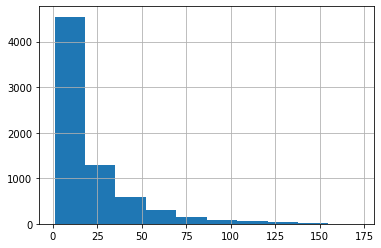

In [22]:
# The histogram plot shows the frequency of rented bike count at each hour
df2['rented_bike_count'].hist()

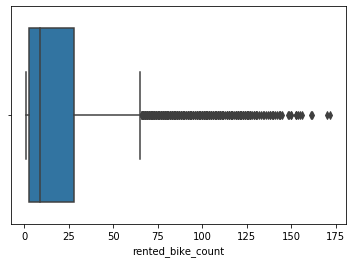

In [23]:
# Boxplot displays the position of the median value of rented_bike_count
# There is a long tail in the data distribution.  
# And, there are many outliers displayed above the upper whisker that are marked with circles.
ax = sns.boxplot(x=df2["rented_bike_count"])

## 1.3 Relationship between variables

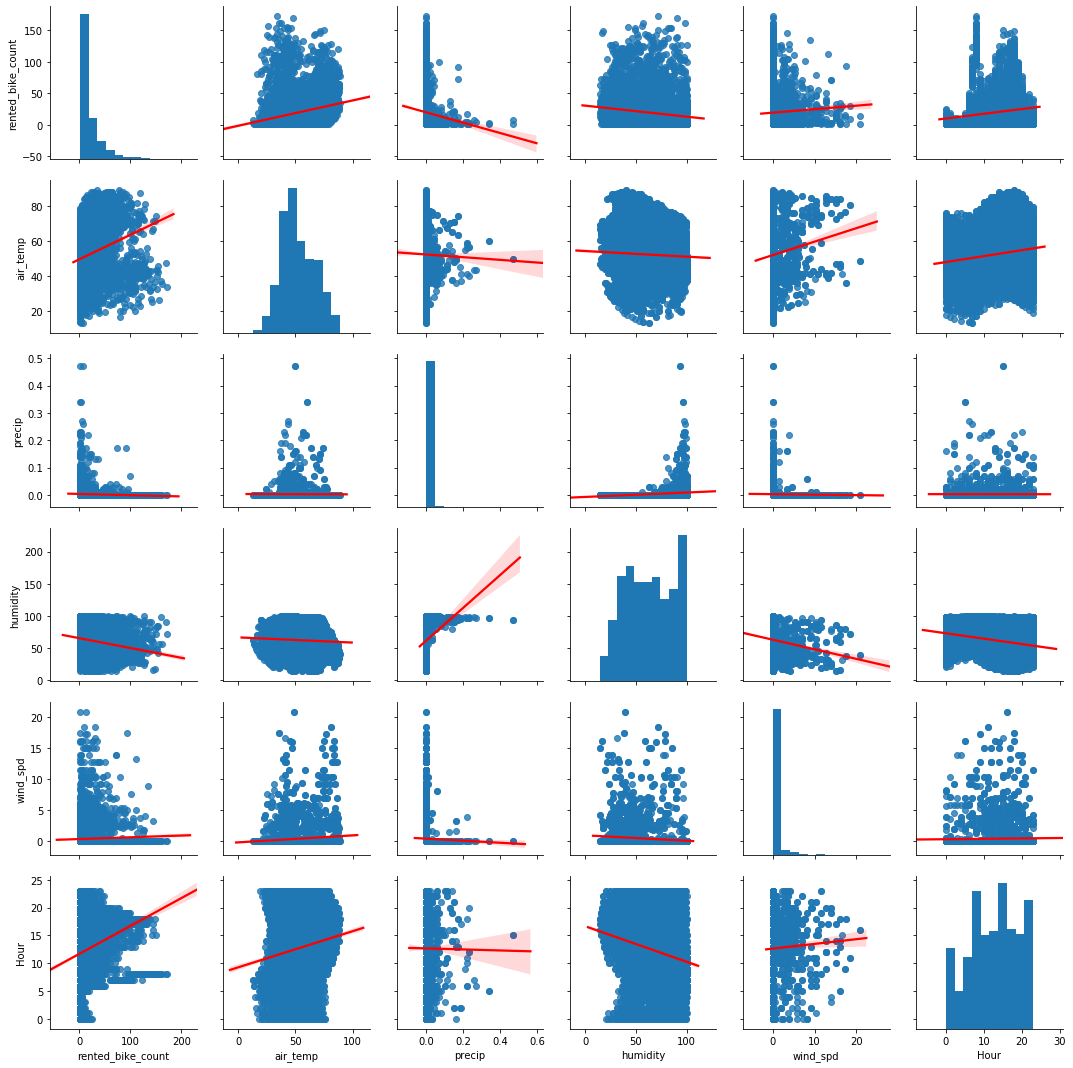

In [24]:
sns.pairplot(df2[['rented_bike_count', 'air_temp', 'precip', 'humidity', 'wind_spd', 'Hour']], 
             kind = 'reg', 
             plot_kws={'line_kws':{'color':'red'}})

### 1.3.1 correlation matrix

In [25]:
corrMatrix = df2.corr()
print (corrMatrix)

                         Hour  air_temp    precip  humidity  wind_spd  \
Hour                 1.000000  0.148367 -0.002672 -0.231083  0.023440   
air_temp             0.148367  1.000000 -0.009672 -0.051073  0.093165   
precip              -0.002672 -0.009672  1.000000  0.203408 -0.017167   
humidity            -0.231083 -0.051073  0.203408  1.000000 -0.113815   
wind_spd             0.023440  0.093165 -0.017167 -0.113815  1.000000   
rented_bike_count    0.193762  0.237059 -0.061105 -0.163073  0.039487   
usertype_Subscriber -0.058140 -0.088710  0.029186  0.039801 -0.013182   

                     rented_bike_count  usertype_Subscriber  
Hour                          0.193762            -0.058140  
air_temp                      0.237059            -0.088710  
precip                       -0.061105             0.029186  
humidity                     -0.163073             0.039801  
wind_spd                      0.039487            -0.013182  
rented_bike_count             1.000000     

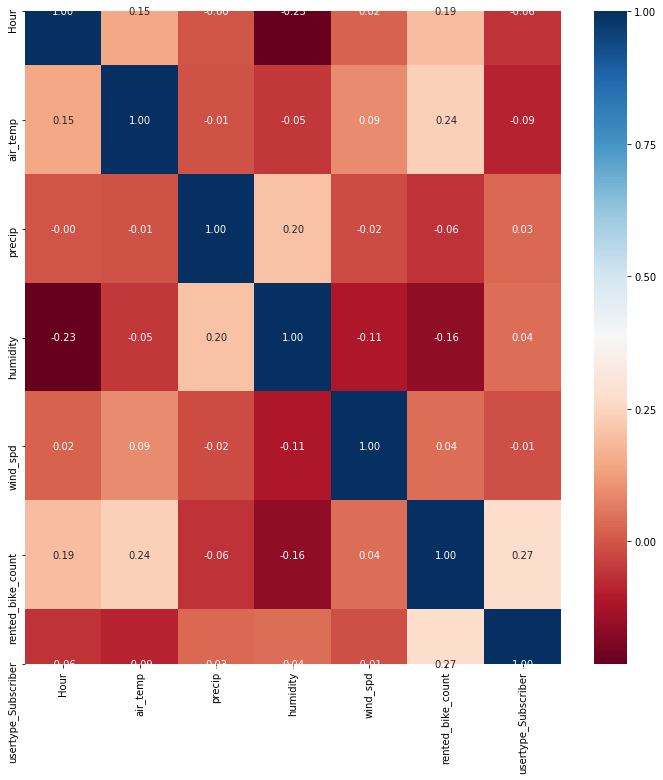

In [26]:
fig, ax = plt.subplots()
fig.set_size_inches(12, 12)
sns.heatmap(corrMatrix, annot=True, fmt=".2f", cmap="RdBu", ax=ax)
plt.show()

### 1.3.2 scatterplots between important variables

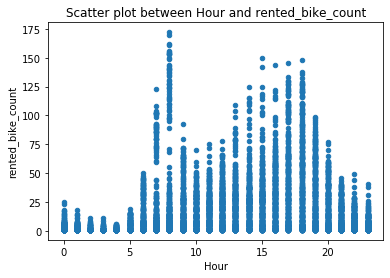

In [27]:
# Scatter plot between Hour and rented_bike_count
df2.plot.scatter(x='Hour', y='rented_bike_count', title= "Scatter plot between Hour and rented_bike_count")

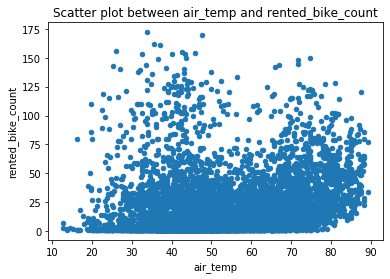

In [28]:
# Scatter plot between air_temp and rented_bike_count
df2.plot.scatter(x='air_temp', y='rented_bike_count', title= "Scatter plot between air_temp and rented_bike_count")

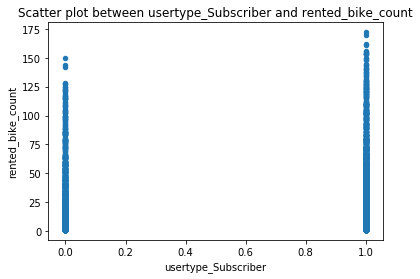

In [29]:
# Scatter plot between usertype_Subscriber and rented_bike_count
df2.plot.scatter(x='usertype_Subscriber', y='rented_bike_count', title= "Scatter plot between usertype_Subscriber and rented_bike_count")

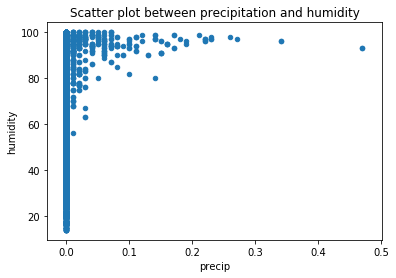

In [30]:
#
df2.plot.scatter(x='precip', y='humidity', title= "Scatter plot between precipitation and humidity")

# 2. Create a baseline model

In [31]:
# define X and y set
X = df2[['air_temp', 'precip', 'humidity', 'wind_spd', 'usertype_Subscriber']]
y = df2['rented_bike_count']

In [32]:
#write a funtion to calculate scores

def scores(model, train_X, valid_X, train_y, valid_y):
    predict_train = model.predict(train_X)
    predict_valid = model.predict(valid_X)
    
    print("Accuracy on train is:", accuracy_score(train_y, predict_train))
    print("Accuracy on valid is:", accuracy_score(valid_y, predict_valid))
    print("Precision score on train is:", precision_score(train_y, predict_train, average='weighted'))
    print("Precision score on valid is:", precision_score(valid_y, predict_valid, average='weighted'))
    print("Recall Score on train is", recall_score(train_y, predict_train, average='weighted'))
    print("Recall Score on valid is", recall_score(valid_y, predict_valid, average='weighted'))
    print("F1 score on train is", f1_score(train_y, predict_train, average='weighted'))
    print("F1 score on valid is", f1_score(valid_y, predict_valid, average='weighted'))

In [33]:
# split data into train and test
train_X, valid_X, train_y, valid_y = train_test_split(X, y, test_size = 0.3, random_state = 1)
print('Traning set:', train_X.shape, 'Validation set:', valid_X.shape)

Traning set: (4952, 5) Validation set: (2123, 5)


In [34]:
# linear regression model
lr = LinearRegression()
lr.fit(train_X, train_y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [35]:
# Ceofficient & Intercept
print('Intercept', lr.intercept_)
print(pd.DataFrame({'Predictor': X.columns, 'Coefficient': lr.coef_}))

Intercept -0.23635948183873978
             Predictor  Coefficient
0             air_temp     0.422611
1               precip   -49.372478
2             humidity    -0.167596
3             wind_spd     0.133257
4  usertype_Subscriber    14.552113


In [36]:
#
lr_pred = lr.predict(valid_X)

result = pd.DataFrame({'Predicted': lr_pred,
                       'Actual': valid_y,
                       'Residual': valid_y - lr_pred})

In [37]:
# 
regressionSummary(valid_y, lr_pred)
print(r2_score(valid_y, lr_pred))


Regression statistics

                      Mean Error (ME) : 0.0481
       Root Mean Squared Error (RMSE) : 22.5477
            Mean Absolute Error (MAE) : 14.6150
          Mean Percentage Error (MPE) : -266.3350
Mean Absolute Percentage Error (MAPE) : 298.2897
0.18165413969958788


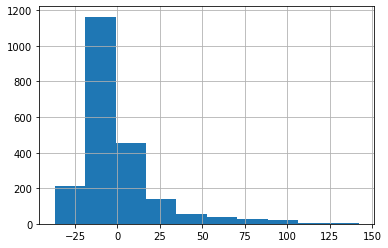

In [38]:
result['Residual'].hist()

In [39]:
log = LogisticRegression()
log.fit(train_X, train_y)

/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [40]:
scores(log, train_X, valid_X, train_y, valid_y)

Accuracy on train is: 0.1470113085621971
Accuracy on valid is: 0.15025906735751296
Precision score on train is: 0.02933459466704091
Precision score on valid is: 0.034730448255451934
Recall Score on train is 0.1470113085621971
Recall Score on valid is 0.15025906735751296
F1 score on train is 0.04513761618351075
F1 score on valid is 0.04827731583210998


/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [41]:
#
nb = GaussianNB()
nb.fit(train_X, train_y)

print(pd.DataFrame({'coeff': nb.theta_[0]}, index = X.columns).transpose())

       air_temp    precip   humidity  wind_spd  usertype_Subscriber
coeff  45.48981  0.005476  70.313859  0.225272             0.313859


In [42]:
scores(nb, train_X, valid_X, train_y, valid_y)

Accuracy on train is: 0.01474151857835218
Accuracy on valid is: 0.0051813471502590676
Precision score on train is: 0.055037731165736216
Precision score on valid is: 0.058113389608591706
Recall Score on train is 0.01474151857835218
Recall Score on valid is 0.0051813471502590676
F1 score on train is 0.01176950170921321
F1 score on valid is 0.006328487399382376


/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


In [44]:
from sklearn.ensemble import VotingClassifier, GradientBoostingClassifier, StackingClassifier, RandomForestClassifier
from mlxtend import StackingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

ImportError: cannot import name 'StackingClassifier' from 'sklearn.ensemble' (/Users/luqinyuan/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/__init__.py)

# 3.	Select only the most important features

In [45]:
estimators = [
('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
('gbm', make_pipeline(StandardScaler(), GradientBoostingClassifier()))
]

clf = StackingClassifier(
estimators=estimators, final_estimator=LogisticRegression()
)

clf.fit(train_X, train_y).score(valid_X, valid_y)

print("precision score: ", precision_score(valid_y,clf.predict(valid_X)))
print("recall score: ", recall_score(valid_y,clf.predict(valid_X)))
print("f1-score: ", f1_score(valid_y,clf.predict(valid_X)))

NameError: name 'RandomForestClassifier' is not defined

# 4.	Feature engineering

# 5. Parameter optimization

# 6. Ensembles & Stacking

# 7. Model building

In [1]:
pwd

'/Users/luqinyuan/Desktop/2020Fall/9660DataMining/group_project'